## Importing libraries and data

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# To display graphs in notebook
%matplotlib inline

In [4]:
path= r'C:\Users\Shelb\OneDrive\Documents\CF Coursework\Advanced Analytics and Dashboard Design\2022 WA State CAFV Project'

In [5]:
# To import previously created subset containing only records where all continuous variables are available
df_general=pd.read_csv(os.path.join(path,'02 Data','Prepared Data','Continuous_Variables_Cleaned.csv'),index_col=False)

In [6]:
df_general.shape

(4513, 8)

In [7]:
df_general.head()

,Unnamed: 0,2015_HB_2778_Eligible?,2019_HB_2042_Eligible?,Sale_Price,Electric_Range,Base_MSRP,Odometer_Reading,Range_Category
0,413,Not Eligible,Not Eligible,20900,208,69900,87891,Long range
1,472,Not Eligible,Not Eligible,53870,14,45600,10,Short range
2,507,Not Eligible,Not Eligible,56015,15,55700,15,Short range
3,779,Not Eligible,Not Eligible,50840,14,90700,17322,Short range
4,795,Not Eligible,Eligible,14999,93,32250,28023,Medium range


##### Sales price, electric range, base MSRP, and odometer reading are not mandatory information for WDOT operations, and as such there are many records in the original Electric Vehicle Title and Registration Activity data set for which this information was not available. df_general contains all records for which there is complete information.

## Dropping unnecessary columns

In [8]:
# To drop Unnamed: 0 and Range_Category columns from df_general
df_general=df_general.drop(columns=['Unnamed: 0'])
df_general=df_general.drop(columns=['Range_Category'])

In [9]:
# To check df_general columns
df_general.columns

Index(['2015_HB_2778_Eligible?', '2019_HB_2042_Eligible?', 'Sale_Price',
       'Electric_Range', 'Base_MSRP', 'Odometer_Reading'],
      dtype='object')

## Data Cleaning

#### Missing values check

In [10]:
# To check for missing values
df_general.isnull().sum()

2015_HB_2778_Eligible?    0
2019_HB_2042_Eligible?    0
Sale_Price                0
Electric_Range            0
Base_MSRP                 0
Odometer_Reading          0
dtype: int64

##### No missing values

#### Duplicates check

In [11]:
# To check for duplicate records
general_dups=df_general.duplicated()
general_dups.shape

(4513,)

##### No duplicate records

#### Extreme values check

C:\Users\Shelb\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Sale_Price', ylabel='Density'>

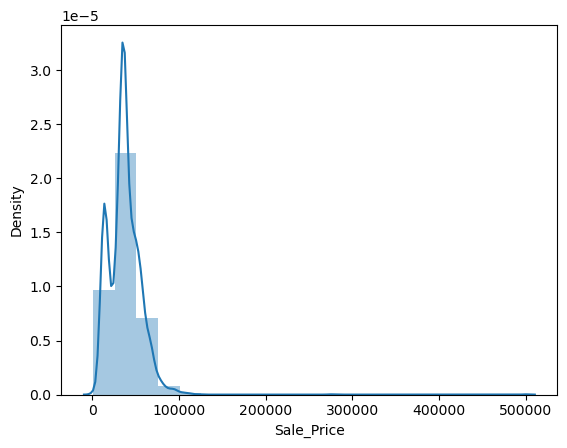

In [12]:
# To check df_general for extreme values
sns.distplot(df_general['Sale_Price'],bins=20)

##### Upon further examination, the most expensive EV on the market as of 2022 was the Rolls-Royce Spectre, whose starting price was 413,000 USD. Values above 413,000 will have the average imputed to remove what is likely to be entry error while retaining the record.

In [13]:
# To impute the average for values above 413,000 in the Sale_Price column
median = df_general.loc[df_general['Sale_Price']<413000, 'Sale_Price'].median()

df_general.loc[df_general.Sale_Price > 413000, 'Sale_Price'] = np.nan

df_general.fillna(median,inplace=True)

C:\Users\Shelb\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Sale_Price', ylabel='Density'>

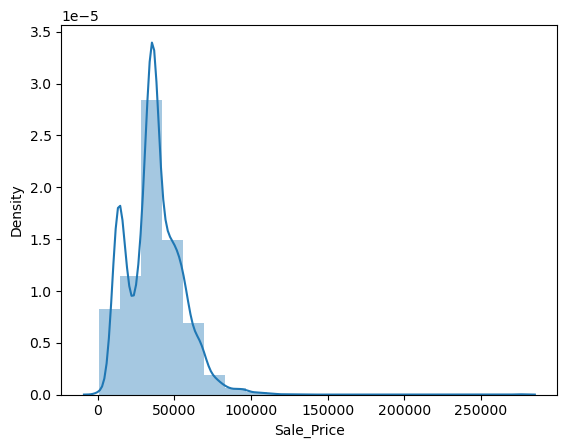

In [14]:
sns.distplot(df_general['Sale_Price'],bins=20)

C:\Users\Shelb\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Base_MSRP', ylabel='Density'>

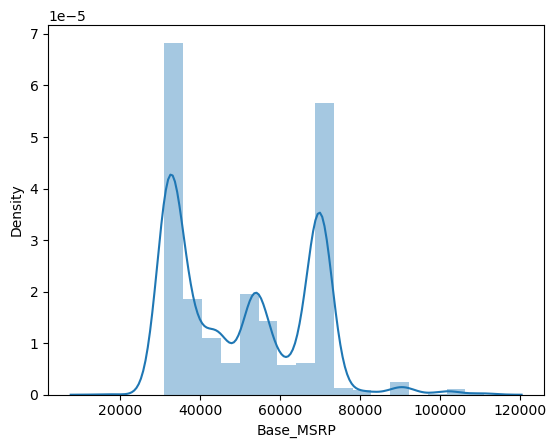

In [15]:
sns.distplot(df_general['Base_MSRP'],bins=20)

C:\Users\Shelb\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Electric_Range', ylabel='Density'>

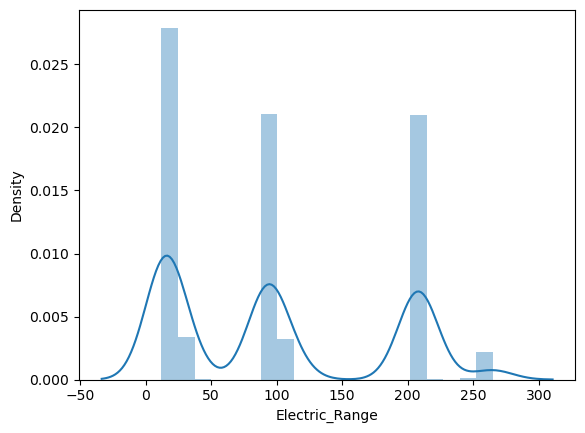

In [16]:
sns.distplot(df_general['Electric_Range'],bins=20)

C:\Users\Shelb\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Odometer_Reading', ylabel='Density'>

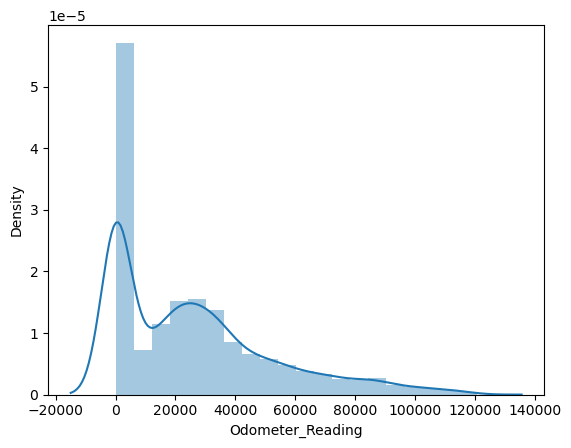

In [17]:
sns.distplot(df_general['Odometer_Reading'],bins=20)

In [18]:
df_general.describe()

,Sale_Price,Electric_Range,Base_MSRP,Odometer_Reading
count,4513.000000,4513.000000,4513.000000,4513.000000
mean,37204.817860,99.156437,50614.541325,25741.869710
std,17369.385023,81.673617,16740.513877,26851.968304
min,750.000000,12.000000,16995.000000,1.000000
25%,26300.000000,17.000000,32250.000000,62.000000
50%,36028.000000,93.000000,52650.000000,20838.000000
75%,47445.000000,208.000000,69900.000000,38739.000000
max,275353.000000,265.000000,110950.000000,120623.000000


## Data preparation for regression analysis

##### During previous exploration electric range and odometer reading were the only pair of variables which had a strong correlation. Here we will test the hypothesis that as a vehicle's electric range increases, so too will its odometer reading.

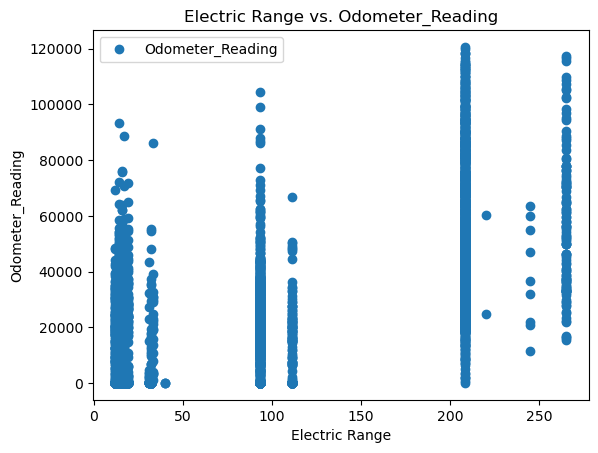

In [19]:
# To create a scatterplot to examine how Electric_Range (independent) amd Odometer Reading (dependent) plot against each other
df_general.plot(x='Electric_Range',y='Odometer_Reading',style='o')
plt.title('Electric Range vs. Odometer_Reading')
plt.xlabel('Electric Range')
plt.ylabel('Odometer_Reading')
plt.show()

In [20]:
# To reshape the variables into numpy arrays and put themm into separate objects
X=df_general['Electric_Range'].values.reshape(-1,1)
y=df_general['Odometer_Reading'].values.reshape(-1,1)

In [21]:
X

array([[208],
       [ 14],
       [ 15],
       ...,
       [208],
       [208],
       [ 17]], dtype=int64)

In [22]:
y

array([[87891],
       [   10],
       [   15],
       ...,
       [50201],
       [27848],
       [  175]], dtype=int64)

In [23]:
# To split the data into a training set and a test set
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3, random_state=0)

## Regression analysis

In [24]:
# To create a regression object to be fit onto the training set
regression=LinearRegression()

In [25]:
# To fit the regression object onto the training set
regression.fit(X_train,y_train)

LinearRegression()

In [26]:
# To predict the value of y using X
y_predicted=regression.predict(X_test)

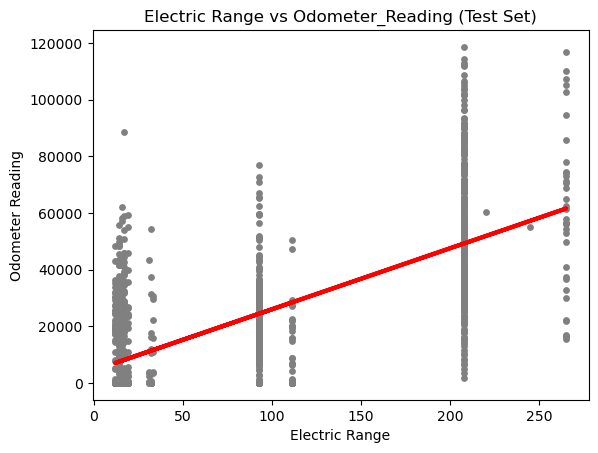

In [27]:
# To create a plot that shows the regression line from the model on the test set
plot_test=plt
plot_test.scatter(X_test, y_test, color='gray',s=15)
plot_test.plot(X_test, y_predicted, color='red', linewidth=3)
plot_test.title('Electric Range vs Odometer_Reading (Test Set)')
plot_test.xlabel('Electric Range')
plot_test.ylabel('Odometer Reading')
plot_test.show()

In [28]:
# To create objects that contain the model summary statistics
rmse=mean_squared_error(y_test,y_predicted)
r2=r2_score(y_test,y_predicted)

In [29]:
# To print teh model summary statistics
print('Slope:',regression.coef_)
print('Mean Squared Error',rmse)
print('R2 Score',r2)

Slope: [[215.41144811]]
Mean Squared Error 398402583.07784796
R2 Score 0.425136412045921


In [30]:
y_predicted

array([[ 7457.83947292],
       [ 7457.83947292],
       [ 7457.83947292],
       ...,
       [49247.66040589],
       [24475.34387346],
       [28352.7499394 ]])

In [36]:
# To create a data frame containing the actual and predicted values of y
data=pd.DataFrame({'Actual':y_test.flatten(),'Predicted':y_predicted.flatten()})
data.head(50)

,Actual,Predicted
0,7,7457.839473
1,26,7457.839473
2,7,7457.839473
3,2755,8104.073817
4,81841,49247.660406
5,25999,24475.343873
6,50311,49247.660406
7,27729,24475.343873
8,42008,49247.660406
9,32209,7673.250921


##### While some predicted y values are fairly close to the actual y values, many of them are off by quite a bit

In [32]:
# To predict
y_predicted_train=regression.predict(X_train)

In [33]:
rmse=mean_squared_error(y_train,y_predicted_train)
r2=r2_score(y_train, y_predicted_train)

In [34]:
print('Slope:',regression.coef_)
print('Mean Squared Error:', rmse)
print('R2 Score:', r2)

Slope: [[215.41144811]]
Mean Squared Error: 420044214.6876974
R2 Score: 0.4265702392002383


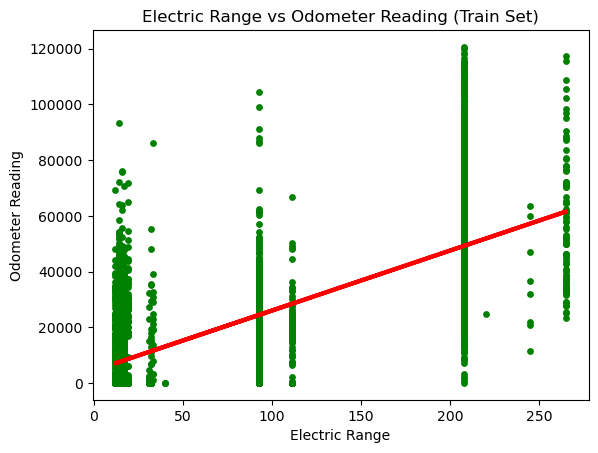

In [35]:
# To visualize training set results
plot_test=plt
plot_test.scatter(X_train,y_train, color='green',s=15)
plot_test.plot(X_train, y_predicted_train, color='red',linewidth=3)
plot_test.title('Electric Range vs Odometer Reading (Train Set)')
plot_test.xlabel('Electric Range')
plot_test.ylabel('Odometer Reading')
plot_test.show()

##### The predicted values don't match the actual values particularly well in this model. Because Electric Range naturally creates a small handful of categories (likely due to the limited variation in battery technology used by EV makers) it is somewhat resistent to regression modeling. While we can observe that electric range and odometer reading have a positive correlation, we can't accurately predict what a vehicle's odometer reading will be given its electric range. Despite the fact that the correlation between odometer reading and electric range is the strongest present among the continuous variables available in the WDOT data, with an R2 score of only about 0.43 the model would make an accurate prediction less than half of the time, and with a mean squared error of about 420,044,215 it would usually miss the mark by quite a lot. Therefore, we can reject the hypothesis that a higher electric range will also mean a higher odometer reading.